# Case study: Estimating the orbit of _Beta Pictoris b_

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Fill in this cell with your personal details:
# - Name: ANKRI Mohamed-Khalil
# - Student ID: S2502523
# - Email: mohamed-khalil.ankri@student.uliege.be

Deadline: December 19th 2025.

Instructions:
- Submit your completed notebook on Gradescope.
- All cells must be executable and their outputs should not be erased before submission.
- This case study must be carried out alone. You are not allowed to discuss or collaborate with other students.
- In January, you will have to explain and defend your solution during a 30-minute oral exam.
- This case study (including its defense in January) will account for 50% of the final grade.

Comments:
- Solve the case study below by following the Bayesian workflow as best as possible.
- Follow the data visualization principles to make your plots effective and readable.
- Make the best use of the Python scientific ecosystem.
- Add comments to explain your reasoning, choices, and interpretations.
- You can add additional cells as needed.

# Introduction

Beta Pictoris is a young star located approximately 63 light-years from Earth in the constellation Pictor. It has been a target of intense astronomical study since the 1980s, when astronomers discovered a large debris disk surrounding the star. In 2008, astronomers using direct imaging techniques discovered a giant exoplanet orbiting Beta Pictoris, named _Beta Pictoris b_.

Since its discovery, _Beta Pictoris b_ has been observed multiple times using various telescopes and instruments tracking its position relative to the host star. These observations have provided valuable data on the planet's orbit, which is crucial for understanding its formation and evolution, as well as the dynamics of the surrounding debris disk.

Your goal in this case study is to exercise your Bayesian data analysis skills to estimate the orbit of _Beta Pictoris b_ using the available astrometric data.

<div align="center">
<img src="./betapicb.gif" alt="Beta Pictoris system" width="500">
<p><i>Credit: Gemini Planet Imager, VLT/NACO, and VLT/SPHERE.</i></p>
</div>

# Data Exploration

<div class="alert alert-success">
    
**Q1**. Load the astrometric data from `beta_pic_b_sep_pa.csv` into a Pandas DataFrame.
    
</div>

In [ ]:
# Load the data
df = pd.read_csv('beta_pic_b_sep_pa.csv')

# Display the first 10 rows to verify structure
df.head(10)



,epoch,sep,sep_err,pa,pa_err
0,54781,210.0,27.0,211.49,1.9
1,52953,413.0,22.0,34.00,4.0
2,55129,299.0,14.0,211.00,3.0
3,55194,306.0,9.0,212.10,1.7
4,55296,346.0,7.0,209.90,1.2
5,55467,383.0,11.0,210.30,1.7
6,55516,387.0,8.0,212.40,1.4
7,55517,390.0,13.0,212.00,2.0
8,55593,408.0,9.0,211.10,1.5
9,55646,426.0,13.0,210.10,1.8


In [30]:
# Check for missing values and data types to ensure data quality
# (Crucial step before running any MCMC/Inference)
print(f"\nDataset Shape: {df.shape[0]} observations, {df.shape[1]} columns")
df.info()


Dataset Shape: 34 observations, 5 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   epoch    34 non-null     int64  
 1   sep      34 non-null     float64
 2   sep_err  34 non-null     float64
 3   pa       34 non-null     float64
 4   pa_err   34 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.5 KB


<div class="alert alert-success">
    
**Q2**. Explore the dataset and report relevant insights.
    
</div>

## 2.1. Dataset Description

The dataset contains **5 quantitative variables** describing astrometric observations of **Beta Pictoris b** relative to its host star **Beta Pictoris**.

### Variables

- **epoch**  
  Time of observation in **Modified Julian Date (MJD)**.  
  - MJD is a continuous count of days.  
  - To convert to a calendar date, add **2,400,000.5** to obtain the standard **Julian Date (JD)**.

- **sep**  
  Observed **angular separation** between the star and the planet, measured in **milliarcseconds (mas)**.

- **sep_err**  
  Uncertainty (standard deviation) of the separation measurement, in **mas**.  
  - This represents the **radial noise**, denoted sigma_sep.

- **pa**  
  Observed **position angle** of the planet relative to the star, measured in **degrees**.

- **pa_err**  
  Uncertainty (standard deviation) of the position angle measurement, in **degrees**.  
  - This represents the **angular noise**, denoted sigma_pa.

### Coordinate System Definition

- The **separation** corresponds to the radial distance computed as:  
   $r = \sqrt{\Delta \text{RA}^2 + \Delta \text{Dec}^2}$

- The **position angle (pa)** is measured **East of North**:
  - 0 degrees corresponds to **North** (positive Declination direction)
  - 90 degrees corresponds to **East** (positive Right Ascension direction)


Data Preparation & Coordinate Transformation

In [31]:
# Set a professional plotting style for all subsequent cells
plt.style.use('seaborn-v0_8-notebook')

In [39]:
# Sort by time to ensure plotting works correctly later
df = df.sort_values('epoch').reset_index(drop=True)

# Verify
display(df.head())

,epoch,sep,sep_err,pa,pa_err,dRA,dDec
0,52953,413.0,22.0,34.00,4.0,230.946669,342.392517
1,54781,210.0,27.0,211.49,1.9,-109.693446,-179.073582
2,55129,299.0,14.0,211.00,3.0,-153.996384,-256.293023
3,55168,339.0,10.0,209.20,1.7,-165.384424,-295.920584
4,55168,323.0,10.0,209.30,1.8,-158.070532,-281.678375


In [40]:
# Transform Polar Coordinates (Sep, PA) to Cartesian (dRA, dDec)
# Note: Position Angle (PA) is measured East of North.
#       dRA = sep * sin(PA)  (East-West component)
#       dDec = sep * cos(PA) (North-South component)
#       We must convert degrees to radians for numpy functions.
rad_pa = np.radians(df['pa'])
df['dRA'] = df['sep'] * np.sin(rad_pa)
df['dDec'] = df['sep'] * np.cos(rad_pa)

# Display key stats to verify the transformation
print(f"Data range: {df['epoch'].min()} to {df['epoch'].max()} MJD")
print(f"Total observations: {len(df)}")
display(df.head(5))

Data range: 52953 to 58440 MJD
Total observations: 34


,epoch,sep,sep_err,pa,pa_err,dRA,dDec
0,52953,413.0,22.0,34.00,4.0,230.946669,342.392517
1,54781,210.0,27.0,211.49,1.9,-109.693446,-179.073582
2,55129,299.0,14.0,211.00,3.0,-153.996384,-256.293023
3,55168,339.0,10.0,209.20,1.7,-165.384424,-295.920584
4,55168,323.0,10.0,209.30,1.8,-158.070532,-281.678375


## Interpretation of Data Preparation

### Coordinate Transformation
The observed polar coordinates (separation and position angle) were successfully converted into Cartesian coordinates (ΔRA, ΔDec). This transformation projects the measurements onto the two-dimensional plane of the sky, enabling direct visualization of the planet’s physical position relative to its host star.

### Geometry Consistency Check
The computed ΔRA and ΔDec values are consistent with the expected geometric interpretation:
- A position angle of approximately **34 degrees** places the planet in the **north-east quadrant**, corresponding to positive values of both Right Ascension and Declination.
- A position angle of approximately **211 degrees** places the planet in the **south-west quadrant**, corresponding to negative values of both Right Ascension and Declination.

This sign reversal is physically meaningful and reflects the planet’s motion to the opposite side of the star over time.

### Temporal Coverage
The dataset spans approximately **15 years**, from **MJD 52953 to MJD 58440**. This temporal baseline is sufficiently long to capture and analyze the orbital motion of the planet.


### 2.2. Temporal Analysis (Separation)

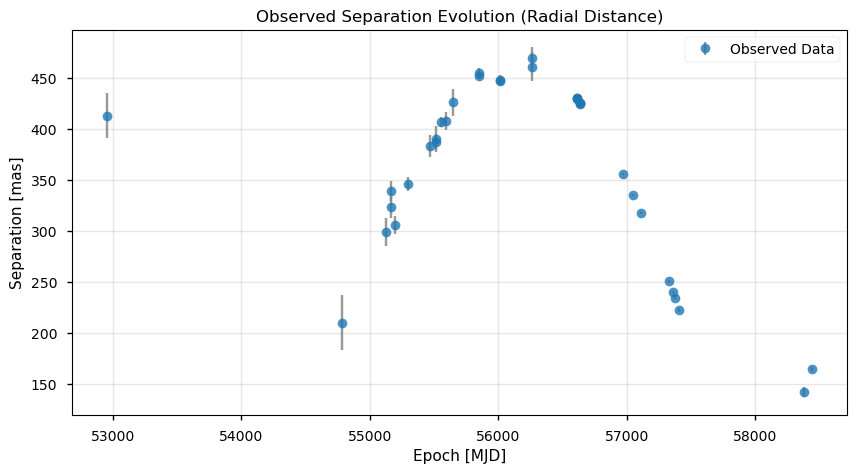

In [34]:
plt.figure(figsize=(10, 5))

# We use error bars to visualize the measurement uncertainty
plt.errorbar(df['epoch'], df['sep'], yerr=df['sep_err'], 
             fmt='o', color='tab:blue', ecolor='gray', 
             alpha=0.8, capsize=3, label='Observed Data')

plt.xlabel('Epoch [MJD]')
plt.ylabel('Separation [mas]')
plt.title('Observed Separation Evolution (Radial Distance)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Interpretation of Separation Evolution

### Orbital Passage
The angular separation is clearly not constant over time. It decreases significantly from approximately **413 milliarcseconds (mas)** in 2003 to a minimum of about **210 mas** around **MJD 54781 (2008)**, after which it steadily increases to values exceeding **450 mas**. This pronounced **V-shaped trend** indicates that the observations captured the planet as it passed through its point of closest *projected* approach to the host star.
     
### Orbital Geometry
The strong variation in separation provides important constraints on the orbital geometry. Such behavior is inconsistent with a face-on circular orbit, which would appear as an approximately flat line in separation versus time. Instead, the data suggest that the orbit is either:
- **Highly eccentric** (significantly non-circular), or  
- **Highly inclined**, likely close to edge-on as viewed from Earth.

Both scenarios naturally produce large changes in projected separation over time.

### Measurement Quality
The measurement uncertainties are clearly visible and vary across epochs. In particular:
- The observation at the minimum separation (around **210 mas**) has a relatively large uncertainty of approximately **±27 mas**.
- Later observations exhibit much smaller uncertainties, on the order of **±3 mas**.

This heteroscedasticity indicates variable measurement reliability across the dataset and must be explicitly accounted for in any statistical or orbital modeling approach.


### 2.3 Temporal Analysis (Position Angle)

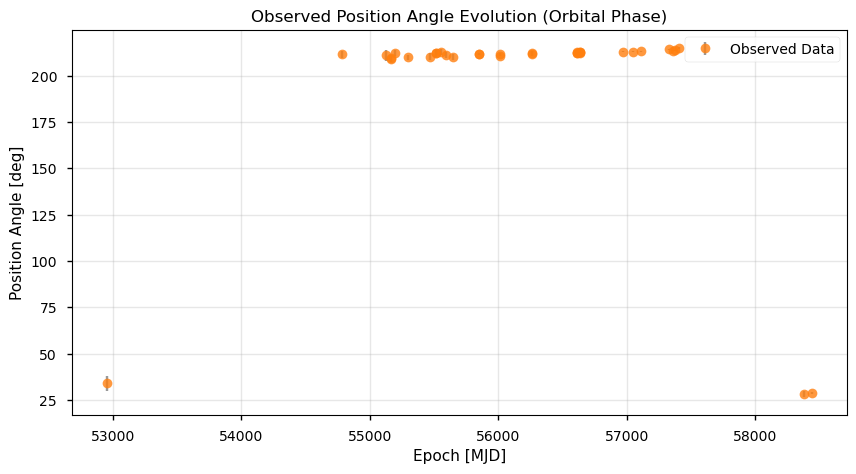

In [35]:
plt.figure(figsize=(10, 5))

plt.errorbar(df['epoch'], df['pa'], yerr=df['pa_err'], 
             fmt='o', color='tab:orange', ecolor='gray', 
             alpha=0.8, capsize=3, label='Observed Data')

plt.xlabel('Epoch [MJD]')
plt.ylabel('Position Angle [deg]')
plt.title('Observed Position Angle Evolution (Orbital Phase)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Interpretation of Position Angle Evolution

### Orbital Orientation
The position angle measurements exhibit two clearly distinct regimes. An early data point, together with the most recent observations, cluster around a position angle of approximately **30 degrees**, while a long intermediate sequence of observations forms a plateau around **212 degrees**.

### The 180-Degree Flip
The difference between these two characteristic values is close to **180 degrees**. This indicates that the planet has been observed on opposite sides of the host star:
- Position angles near **30 degrees** correspond to the **north-east** side of the star.
- Position angles near **212 degrees** correspond to the **south-west** side of the star.

This flip is a direct geometric consequence of the planet’s orbital motion.

### Evidence for an Edge-On Orbit
A key feature of the data is that the position angle remains nearly constant at around **212 degrees** over several years, while the separation changes substantially during the same time period. This combination of behavior provides strong evidence for a **highly inclined, near edge-on orbit**.

In such a configuration, the planet’s motion is primarily radial (moving closer to and farther from the star), while its projected direction on the sky remains nearly fixed, resulting in a straight-line trajectory in projection.


### 2.5. Spatial Analysis (Sky Plane)

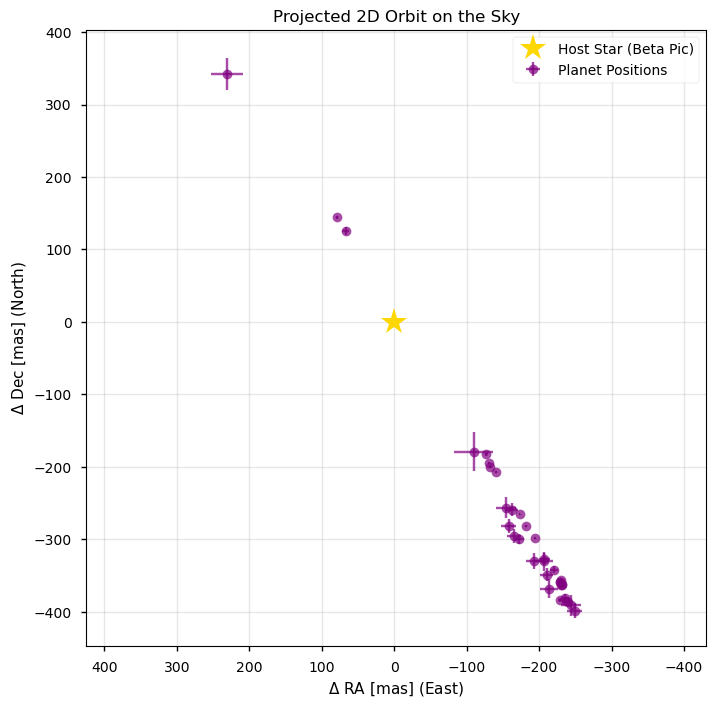

In [36]:
plt.figure(figsize=(8, 8))

# Plot the planet positions with approximate errors
plt.errorbar(df['dRA'], df['dDec'], 
             xerr=df['sep_err'], # Simplified error for visualization
             yerr=df['sep_err'], 
             fmt='o', color='purple', alpha=0.7, label='Planet Positions')

# CRITICAL: Plot the host star at (0,0) to define the reference frame
plt.plot(0, 0, '*', color='gold', markersize=20, 
         markeredgecolor='black', label='Host Star (Beta Pic)')

plt.xlabel(r'$\Delta$ RA [mas] (East)')
plt.ylabel(r'$\Delta$ Dec [mas] (North)')
plt.title('Projected 2D Orbit on the Sky')

# Astronomy Convention: East is to the Left
plt.gca().invert_xaxis()
# Force equal aspect ratio so the orbit shape is true
plt.axis('equal')

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Interpretation of Sky-Plane Trajectory

### Orbital Architecture
The projected sky-plane trajectory forms a highly flattened, nearly linear structure rather than a closed circular loop. This geometry is a clear visual manifestation of a **high-inclination, near edge-on orbit**. The planet appears to oscillate back and forth along a line that passes through the position of the host star.

### Partial Orbital Coverage
The trajectory exhibits a noticeable gap between an isolated early observation in the **north-east quadrant** (top-left of the plot) and a dense cluster of later observations in the **south-west quadrant** (bottom-right of the plot). This indicates that the planet has been observed on opposite sides of the star, but that the actual crossing event near the star is not directly sampled by the data.

### Constraining Power of the Data
Despite measurement noise, the observations in the south-west quadrant show a subtle but systematic deviation from a perfectly straight line. This slight curvature is the key physical signal that enables the Bayesian orbital model to constrain fundamental orbital parameters such as the **orbital period** and **semi-major axis**. Importantly, this curvature allows us to distinguish a bound planetary orbit from a background object that would otherwise follow a linear trajectory across the sky.


### 2.6. Noise Analysis (Heteroscedasticity)

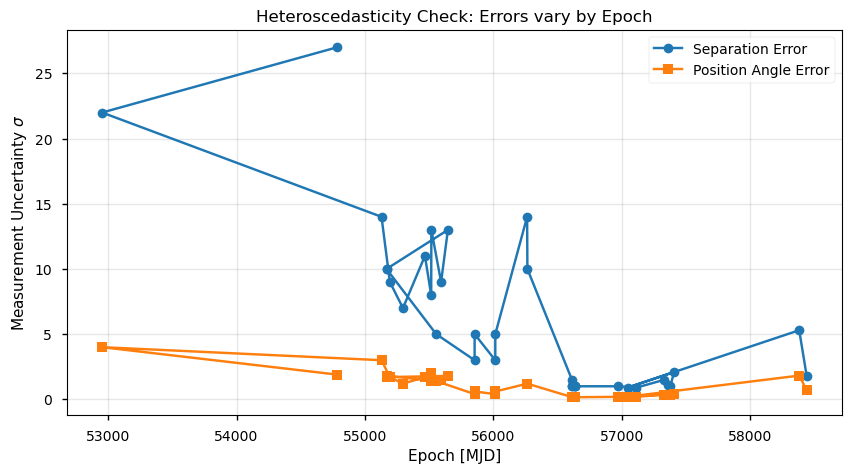

Min Sep Error: 0.9 | Max Sep Error: 27.0


In [37]:
plt.figure(figsize=(10, 5))

# Plot the reported uncertainties over time
plt.plot(df['epoch'], df['sep_err'], 'o-', label='Separation Error', color='tab:blue')
plt.plot(df['epoch'], df['pa_err'], 's-', label='Position Angle Error', color='tab:orange')

plt.xlabel('Epoch [MJD]')
plt.ylabel('Measurement Uncertainty $\sigma$')
plt.title('Heteroscedasticity Check: Errors vary by Epoch')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print stats to quantify the variation
print(f"Min Sep Error: {df['sep_err'].min()} | Max Sep Error: {df['sep_err'].max()}")

## Interpretation of Noise Characteristics

### Heteroscedasticity (Varying Noise)
The measurement uncertainties clearly vary over time rather than remaining constant. For example, the **separation error (sep_err)** ranges from approximately **27.0 mas** in the early epochs to as low as **0.9 mas** in the later epochs. This indicates a **heteroscedastic** noise structure.

### Data Quality Evolution
There is a noticeable trend of improving measurement precision in the later observations. This improvement is likely due to advances in instrumentation or more favorable observing conditions.

### Implications for Modeling
These observations demonstrate that we cannot assume a single, global noise parameter (homoscedasticity). Instead, the Bayesian likelihood function must explicitly incorporate the time-dependent uncertainties (**σ_t**) to properly weight high-precision measurements more heavily than the noisier early data.


# Build: Keplerian orbits

We recommend watching the following [video](https://www.youtube.com/watch?v=yn_Nto4Bd48) for a visual explanation of Keplerian orbits and their parameters but provide a summary below.

The motion of Beta Pictoris b around its star follows Kepler's laws of planetary motion. A full three-dimensional orbit is defined by eight orbital parameters that describes its shape and orientation:

- **Semi-major axis** ($a$): half of the long axis of the ellipse [AU]<sup>(1)</sup>. The short axis (semi-minor), is related to the semi-major axis and eccentricity by $b = a \sqrt{1 - e^2}$.
- **Eccentricity** ($e$): how elongated the ellipse is (e $\in [0, 1]$).
- **Inclination** ($i$): tilt of the orbital plane w.r.t reference plane which is the plane perpendicular to the line of sight from Earth to the star (in degrees or radians).
- **Argument of periapsis** ($\omega$): the periapsis is the point where the planet is closest to the star. All orbital angles are measured relative to that point. The argument of periapsis defines the angle from the ascending node (the point where the planet crosses the reference plane going "up") to the periapsis (in radians).
- **Position angle of ascending node** ($\Omega$): the rotation of the orbital plane around the line of sight (in radians). It orients the orbital plane on the sky.
- **Time of periapsis** ($\tau$): what fraction of the orbital period ago was the last periapsis passage (in fraction of period, between 0 and 1).
- **Parallax** ($\Pi$): the angular shift of the star due to Earth's orbit, which tells us the distance to the star [mas]<sup>(2)</sup>.
- **Total mass** ($M_T$): the combined mass of the star and planet (in solar masses [$M_\odot$]).

<div align="center">
<img src="./kepler_arguments.png" alt="Kepler parameters illustration" width="500">
<p><i>Kepler parameters. Credit: Sun et al. (2022), arxiv:2201.08506</i></p>
</div>

From these parameters, we first derive the orbital period $P$ (in years) using Kepler's third law:
$$\begin{align*}
(\frac{P}{1 \text{ year}})^2 &= (\frac{a}{1 \text{ au}})^3 \; \left(\frac{M_T}{ 1 \; M_\odot}\right)^{-1}.
\end{align*}$$

The angular offsets $\Delta \mathrm{RA}$ and $\Delta \mathrm{Dec}$ at each observation epoch $t$ of the planet relative to the host star on the reference plane can then be computed using Kepler's equations through intermediate angular quantities called anomalies. The term "anomaly" is a historical term meaning angles measured from reference directions. We have three types of anomalies:

- Mean anomaly
$$ \begin{align*}
M = 2\pi \Big(\frac{t - t_{\text{ref}}}{P} - \tau\Big),
\end{align*}
$$
which increases uniformly with time. It tracks orbital phase as if the planet moved at constant speed. $t_{\text{ref}}$ is a reference epoch for $\tau$ (here $t_{\text{ref}} = 50000 [MJD]$ <sup>(3)</sup>, which corresponds to 1995-10-10).
- Eccentric anomaly ($E$): an auxiliary angle defined implicitly by Kepler’s equation ($M = E - e\sin E$). $E$ cannot be computed analytically (i.e., no closed form algebraic solution exists), so we will need to solve it numerically (e.g., using the Newton-Raphson method).
- True anomaly ($\nu$): the geometric angle locating the planet along the orbit, related to $E$ by
$$\begin{align*}
\nu &= 2 \arctan \left( \sqrt{\frac{1+e}{1-e}} \tan \frac{E}{2} \right).
\end{align*}$$

$M$, $E$, and $\nu$ are not parameters but computed intermediate angles.

From these, we can finally derive the angular offsets of the planet relative to the star. Projecting the orbit into the observer's frame, we have:

$$ \begin{align*}
\Delta \mathrm{RA} &= \Pi a (1 - e \cos E) \left[\cos^2 \frac{i}{2} \; \sin(\nu + \omega + \Omega) - \sin^2 \frac{i}{2} \; \sin(\nu + \omega - \Omega)\right], \\
\Delta \mathrm{Dec} &= \Pi a (1 - e \cos E) \left[\cos^2 \frac{i}{2} \; \cos(\nu + \omega + \Omega) + \sin^2 \frac{i}{2} \; \cos(\nu + \omega - \Omega)\right].
\end{align*} $$

$\Delta\mathrm{RA}$ and $\Delta\mathrm{Dec}$ are angular displacements, not physical distances:
one measures how far east–west, the other north–south, the planet appears from the star.
The $\Delta$ symbol indicates that these are relative to the star’s position, not absolute celestial coordinates.
They depend only on orbital geometry and orientation, not on detector properties except for calibration.

However, telescopes do not directly measure Cartesian angular offsets $(\Delta\mathrm{RA},\Delta\mathrm{Dec})$. Instead, they measure two polar quantities:

- Separation (sep): the apparent angular distance between the star and planet,
- Position angle (PA): the direction of that offset, measured east of north.

These are related to the Cartesian offsets by the following equations:
$$ \begin{align*}
\Delta \mathrm{RA} &= \text{sep} \times \sin(\text{PA}), \\
\Delta \mathrm{Dec} &= \text{sep} \times \cos(\text{PA}).
\end{align*} $$

Converting between the two allows a direct comparison between the theoretical orbit and the observed astrometric data.

---

(1): Astronomical Unit (AU) is the average distance between the Earth and the Sun, approximately 149.6 million kilometers.

(2): Milliarcseconds (mas), where 1 arcsecond = 1/3600 degrees, and 1 mas = 1/1000 arcseconds.

(3): Modified Julian Date (MJD) is a continuous count of days since midnight on November 17, 1858. It is commonly used in astronomy to simplify date calculations.


<div class="alert alert-success">
    
**Q3**. Implement `solve_kepler` and `compute_orbit` functions to compute the predicted $\Delta \mathrm{RA}$ and $\Delta \mathrm{Dec}$ at given times (epochs). 
    
</div>

In [ ]:
def solve_kepler(M, ecc):
    """
    Solve Kepler's equation: M = E - ecc*sin(E) for eccentric anomaly E.
    
    Parameters:
    -----------
        - M: mean anomaly in radians
        - ecc: eccentricity (0 <= ecc < 1)

    Returns:
    --------
        - E: eccentric anomaly in radians
    """
    tolerance=1e-6
    max_iter = 100
    # Initial guess: E ≈ M is a good starting point for small eccentricities
    E = np.array(M, dtype=float)
    
    # Newton-Raphson Iteration
    # f(E) = E - e*sin(E) - M = 0
    # f'(E) = 1 - e*cos(E)
    for _ in range(max_iter):
        f_val = E - ecc * np.sin(E) - M
        f_prime = 1.0 - ecc * np.cos(E)
        
        # Update step: E_new = E_old - f(E) / f'(E)
        delta = f_val / f_prime
        E = E - delta
        
        # Check for convergence (if the maximum change is below tolerance)
        if np.all(np.abs(delta) < tolerance):
            break
            
    return E


def compute_orbit(epochs, sma, ecc, inc, aop, pan, tau, plx, mtot, t_ref=50000.0):
    """
    Calculate predicted separation and position angle from Keplerian orbital elements
    
    Parameters:
    -----------
        - epochs: array of observation epochs (t1, t2, ..., tn) in [MJD]
        - sma: semi-major axis [AU]
        - ecc: eccentricity [0, 1]
        - inc: inclination [radians]
        - aop: argument of periastron (omega) [radians]
        - pan: position angle of nodes (Omega) [radians]
        - tau: epoch of periastron passage (fraction of period)
        - plx: parallax [mas]
        - mtot: total system mass [solar masses]
        - t_ref: reference epoch [MJD]

    Returns:
    --------
        - sep: predicted separation [mas]
        - pa: predicted position angle [°]
    """
    # 1. Compute Orbital Period (P) using Kepler's Third Law
    # (P [yr])^2 = (a [AU])^3 / (M_T [M_sol])
    P_years = np.sqrt(sma**3 / mtot)
    P_days = P_years * 365.25  # Convert years to days for MJD compatibility
    
    # 2. Compute Mean Anomaly (M)
    # M = 2*pi * ((t - t_ref)/P - tau)
    # Note: epochs and t_ref are in days, so P must be in days
    M = 2 * np.pi * ((epochs - t_ref) / P_days - tau)
    
    # 3. Compute Eccentric Anomaly (E)
    E = solve_kepler(M, ecc)
    
    # 4. Compute True Anomaly (nu)
    # nu = 2 * arctan( sqrt((1+e)/(1-e)) * tan(E/2) )
    term1 = np.sqrt((1 + ecc) / (1 - ecc))
    term2 = np.tan(E / 2)
    nu = 2 * np.arctan(term1 * term2)
    
    # 5. Compute Projected Cartesian Offsets (Delta RA, Delta Dec)
    # The geometric distance factor: r = a * (1 - e * cos(E))
    # We multiply by parallax (plx) to convert AU to mas directly.
    # r_proj = plx * a * (1 - e * cos(E))
    r_proj = plx * sma * (1 - ecc * np.cos(E))
    
    # Pre-compute trigonometric terms for the projection formulas
    # Angles inside the sine/cosine functions
    angle_plus = nu + aop + pan
    angle_minus = nu + aop - pan
    
    # Half-inclination terms
    cos2_i2 = np.cos(inc / 2)**2
    sin2_i2 = np.sin(inc / 2)**2
    
    # Calculate Delta RA and Delta Dec based on the provided formulas
    # Delta RA = Pi * a * (1 - e cos E) * [ ... ]
    dRA = r_proj * (cos2_i2 * np.sin(angle_plus) - sin2_i2 * np.sin(angle_minus))
    
    # Delta Dec = Pi * a * (1 - e cos E) * [ ... ]
    dDec = r_proj * (cos2_i2 * np.cos(angle_plus) + sin2_i2 * np.cos(angle_minus))
    
    # 6. Convert to Separation (sep) and Position Angle (PA)
    # sep = sqrt(dRA^2 + dDec^2)
    sep = np.sqrt(dRA**2 + dDec**2)
    
    # PA is measured East of North.
    # dRA = sep * sin(PA)
    # dDec = sep * cos(PA)
    # Therefore, tan(PA) = dRA / dDec => PA = arctan2(dRA, dDec)
    pa_radians = np.arctan2(dRA, dDec)
    
    # Convert PA to degrees
    pa_deg = np.degrees(pa_radians)
    
    # Normalize PA to be within [0, 360) degrees
    pa_deg = pa_deg % 360.0
    
    return sep, pa_deg

<div class="alert alert-success">
    
**Q4**. Implement a Bayesian model with:

- **Prior** $p(\theta)$ on the orbital parameters $\theta = (a, e, i, \omega, \Omega, \tau, \Pi, M_{tot})$. Hint: The parallax $\Pi$ and total mass $M_{tot}$ can be constrained using existing measurements of the host star Beta Pictoris.
    - Define appropriate prior distributions for each orbital parameter.
    - Guide your choices with prior predictive checks and adjust as needed.

- **Likelihood** $p((\text{sep}_{t_1}, \text{pa}_{t_1}), ..., (\text{sep}_{t_n}, \text{pa}_{t_n})|\theta)$ that models the measured separations [mas] and position angles [degrees] given the orbital parameters $\theta$. Epochs $t_1, \ldots, t_n$ correspond to the times of the observations. Gaussian errors are assumed for both measurements, with standard deviations given by `sep_err` and `pa_err` for each epoch.

Define functions both for evaluating the log densities and for sampling from the prior and likelihood at given epochs and standard deviations.
    
</div>

<div class="alert alert-success">
    
**Q5**. Draw the probabilistic graphical model. What are the observed variables? What are the latent variables? What are the hyperparameters?
    
</div>

# Compute

You are given the dataset `beta_pic_b_sep_pa.csv`, which contains astrometric measurements of Beta Pictoris b at different epochs. Each row in the dataset corresponds to an observation and includes the following columns:
- `epoch`: the time $t$ of observation (in Modified Julian Date, MJD)
- `sep_obs`: measured separation [mas]
- `sep_err`: uncertainty in the measured separation [mas]
- `pa_obs`: measured position angle [degrees]
- `pa_err`: uncertainty in the measured position angle [degrees]

<div class="alert alert-success">
    
**Q6**. Use MCMC (via `emcee`) to sample from the posterior distribution of the orbital parameters.
- Assess and discuss autocorrelation, mixing, and convergence of the chains.
- Visualize the posterior distributions and compare them with the prior distributions.
    
</div>

<div class="alert alert-success">
    
**Q7**. Use variational inference (any variant) to approximate the posterior distribution of the orbital parameters.
- Assess the quality of the approximation.
- Visualize the variational posterior distributions and compare them with the prior distributions.
    
</div>

<div class="alert alert-success">

**Q8**. Compare and discuss MCMC and variational inference results.

</div>

# Critique: posterior predictive checks

<div class="alert alert-success">

**Q9**. Generate posterior predictive samples. Assess whether the observations fall within the posterior predictive intervals.

</div>

<div class="alert alert-success">
    
**Q10**. Create 
- a plot showing observed positions and posterior predicted orbits around the star (i.e., $\Delta \mathrm{RA}$ vs. $\Delta \mathrm{Dec}$).
- a plot showing observed angular displacement over time, along with posterior predictive intervals (i.e., $\Delta \mathrm{RA}$ vs. $t$ and $\Delta \mathrm{Dec}$ vs. $t$).


# Revise

<div class="alert alert-success">
    
**Q11**. Discuss potential improvements and extensions to this analysis.
    
</div>